# Effective Stiffness of Fiber Composite



## Introduction

This example demonstrates the use of an homogenization model to predict the macroscopic stress in fiber-like structures. The structures emulate fiber-reinforced polymer samples. For a summary of homogenization theory and its use with effective stiffness properties please see the [Effective Siffness example](http://materialsinnovation.github.io/pymks/rst/stress.html). The example generates a series of random microstructures with various fiber lengths and volume fractions. The structures are used to calibrate and test the homegnization model against the simulated effective stress values.

In [1]:
import warnings
import os

os.environ["OMP_NUM_THREADS"] = "1"
warnings.filterwarnings('ignore')

import dask.array as da
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from dask_ml.decomposition import PCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D

from pymks.fmks.data.multiphase import generate
from pymks.fmks.data.elastic_fe import solve
from pymks.fmks.plot import plot_microstructures
from pymks.fmks.bases.primitive import PrimitiveTransformer
from pymks.fmks.correlations import TwoPointCorrelation, FlattenTransformer

#import numpy as np
#import matplotlib.pyplot as plt
#from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import PolynomialFeatures
#from sklearn.pipeline import Pipeline
#from pymks.fmks.correlations import auto_correlation
#from sklearn.decomposition import PCA
#import pandas
#from pymks.fmks.bases.primitive import PrimitiveTransformer
#from pymks.fmks.correlations import TwoPointCorrelation,FlattenTransformer
#from pymks.datasets import make_elastic_stress_random
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
#from toolz.curried import groupby, get, pipe, valmap, merge_with, merge, valmap, pluck
#from toolz.curried import map as map_
#from pymks.fmks.func import sequence

In [2]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data Generation

The following generates four different types of microstructures each with 200 samples with spatial dimensions of 31 x 31. The grains have a high aspect ratio to simulate fiber-like structures.

In [3]:
da.random.seed(10)
np.random.seed(10)


tmp = [
    generate(
        shape=(100, 31, 31),
        grain_size=grain_size,
        volume_fraction=volume_fraction,
        chunks=50,
        percent_variance=0.2
    )
    for (grain_size, volume_fraction) in zip(
        [(30, 2), (7, 2), (2, 30), (2, 7)],
        [(0.7, 0.3), (0.6, 0.4), (0.3, 0.7), (0.4, 0.6)]
    )
]

x_data = da.concatenate(tmp).persist()

In [4]:
y_stress = solve(x_data,
                 elastic_modulus=(1.3, 2.5),
                 poissons_ratio=(0.42, 0.35),
                 macro_strain=0.001)['stress'][..., 0].persist()

y_data = da.average(y_stress.reshape(y_stress.shape[0], -1), axis=1).persist()

The arrays have been computed by calling the `persist` method.

In [5]:
x_data

dask.array<concatenate, shape=(400, 31, 31), dtype=int64, chunksize=(50, 31, 31), chunktype=numpy.ndarray>

In [6]:
y_data

dask.array<mean_agg-aggregate, shape=(400,), dtype=float64, chunksize=(50,), chunktype=numpy.ndarray>

## View Microstructures

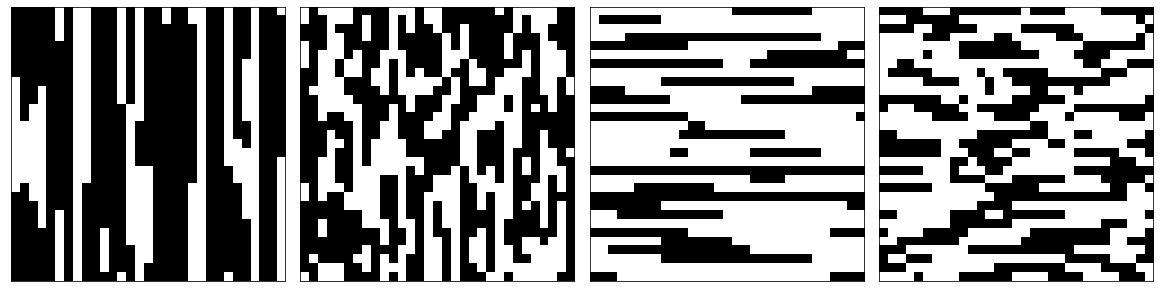

In [7]:
plot_microstructures(*x_data[::100], cmap='gray', colorbar=False)

In [8]:
y_stress.shape

(400, 31, 31)

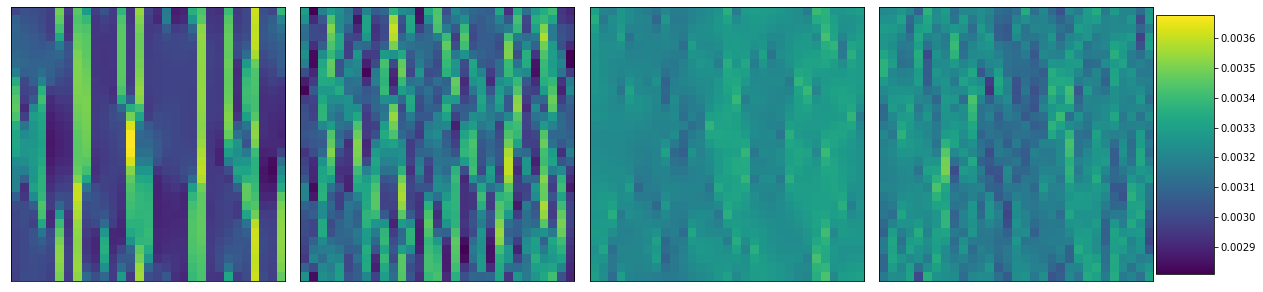

In [9]:
plot_microstructures(*y_stress[::100])

In [10]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

y_data[::100].compute()

array([0.00312662, 0.00316098, 0.00324699, 0.00320639])

## The Model

The following creates an homogenization pipeline and cross-validates the model. For more details about the two-points statistics view the [Checkerboard Microstructure Example](http://materialsinnovation.github.io/pymks/rst/checker_board.html).

### Note (issue or bug)

There are currently two issues with the pipeline.

 - The `svd_solver='full'` argument is required in the pipeline as the results are not correct without it. This might be an issue with Dask's PCA algorithms and needs further investigation.
 
 - Dask's `LinearRegression` module does not seem to solve this problem correctly and gives very different results to Sklearn's. Needs further investigation. Using Sklearn's instead.

In [11]:
pca_steps = [
    ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ("correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=31, correlations=[(0, 1), (1, 1)])),
    ('flatten', FlattenTransformer()),  
    ('pca',PCA(n_components=3, svd_solver='full', random_state=999))
]

pca_pipeline = Pipeline(steps=pca_steps)

pipeline = Pipeline(steps=pca_steps + [
    ('poly', PolynomialFeatures()),
    ('regressor', LinearRegression())
])



## Training and testing data sets

Split the data into testing and training segments for computations in the rest of the notebook

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
    x_data.reshape(x_data.shape[0], -1),
    y_data,
    test_size=0.2,
    random_state=3
)

## Visualize the task graph

The pipeline results in an entirely lazy calulation. The task graph can be viewed to check that it remains parallel and doesn't gather all the data. The calculation has not been evaluated yet, since the graph is generated with only a small part of the data.

### Note (issue or bug)

Note that for some reason the `y_train` passed into `fit` is required to be a Numpy array and doens't work with a correctly chunked Dask array, see the [github issue](https://github.com/materialsinnovation/pymks/issues/474).

Fontconfig warning: "/etc/fonts/fonts.conf", line 5: unknown element "its:rules"
Fontconfig warning: "/etc/fonts/fonts.conf", line 6: unknown element "its:translateRule"
Fontconfig error: "/etc/fonts/fonts.conf", line 6: invalid attribute 'translate'
Fontconfig error: "/etc/fonts/fonts.conf", line 6: invalid attribute 'selector'
Fontconfig error: "/etc/fonts/fonts.conf", line 7: invalid attribute 'xmlns:its'
Fontconfig error: "/etc/fonts/fonts.conf", line 7: invalid attribute 'version'
Fontconfig warning: "/etc/fonts/fonts.conf", line 9: unknown element "description"
Fontconfig error: Cannot load config file from /etc/fonts/fonts.conf


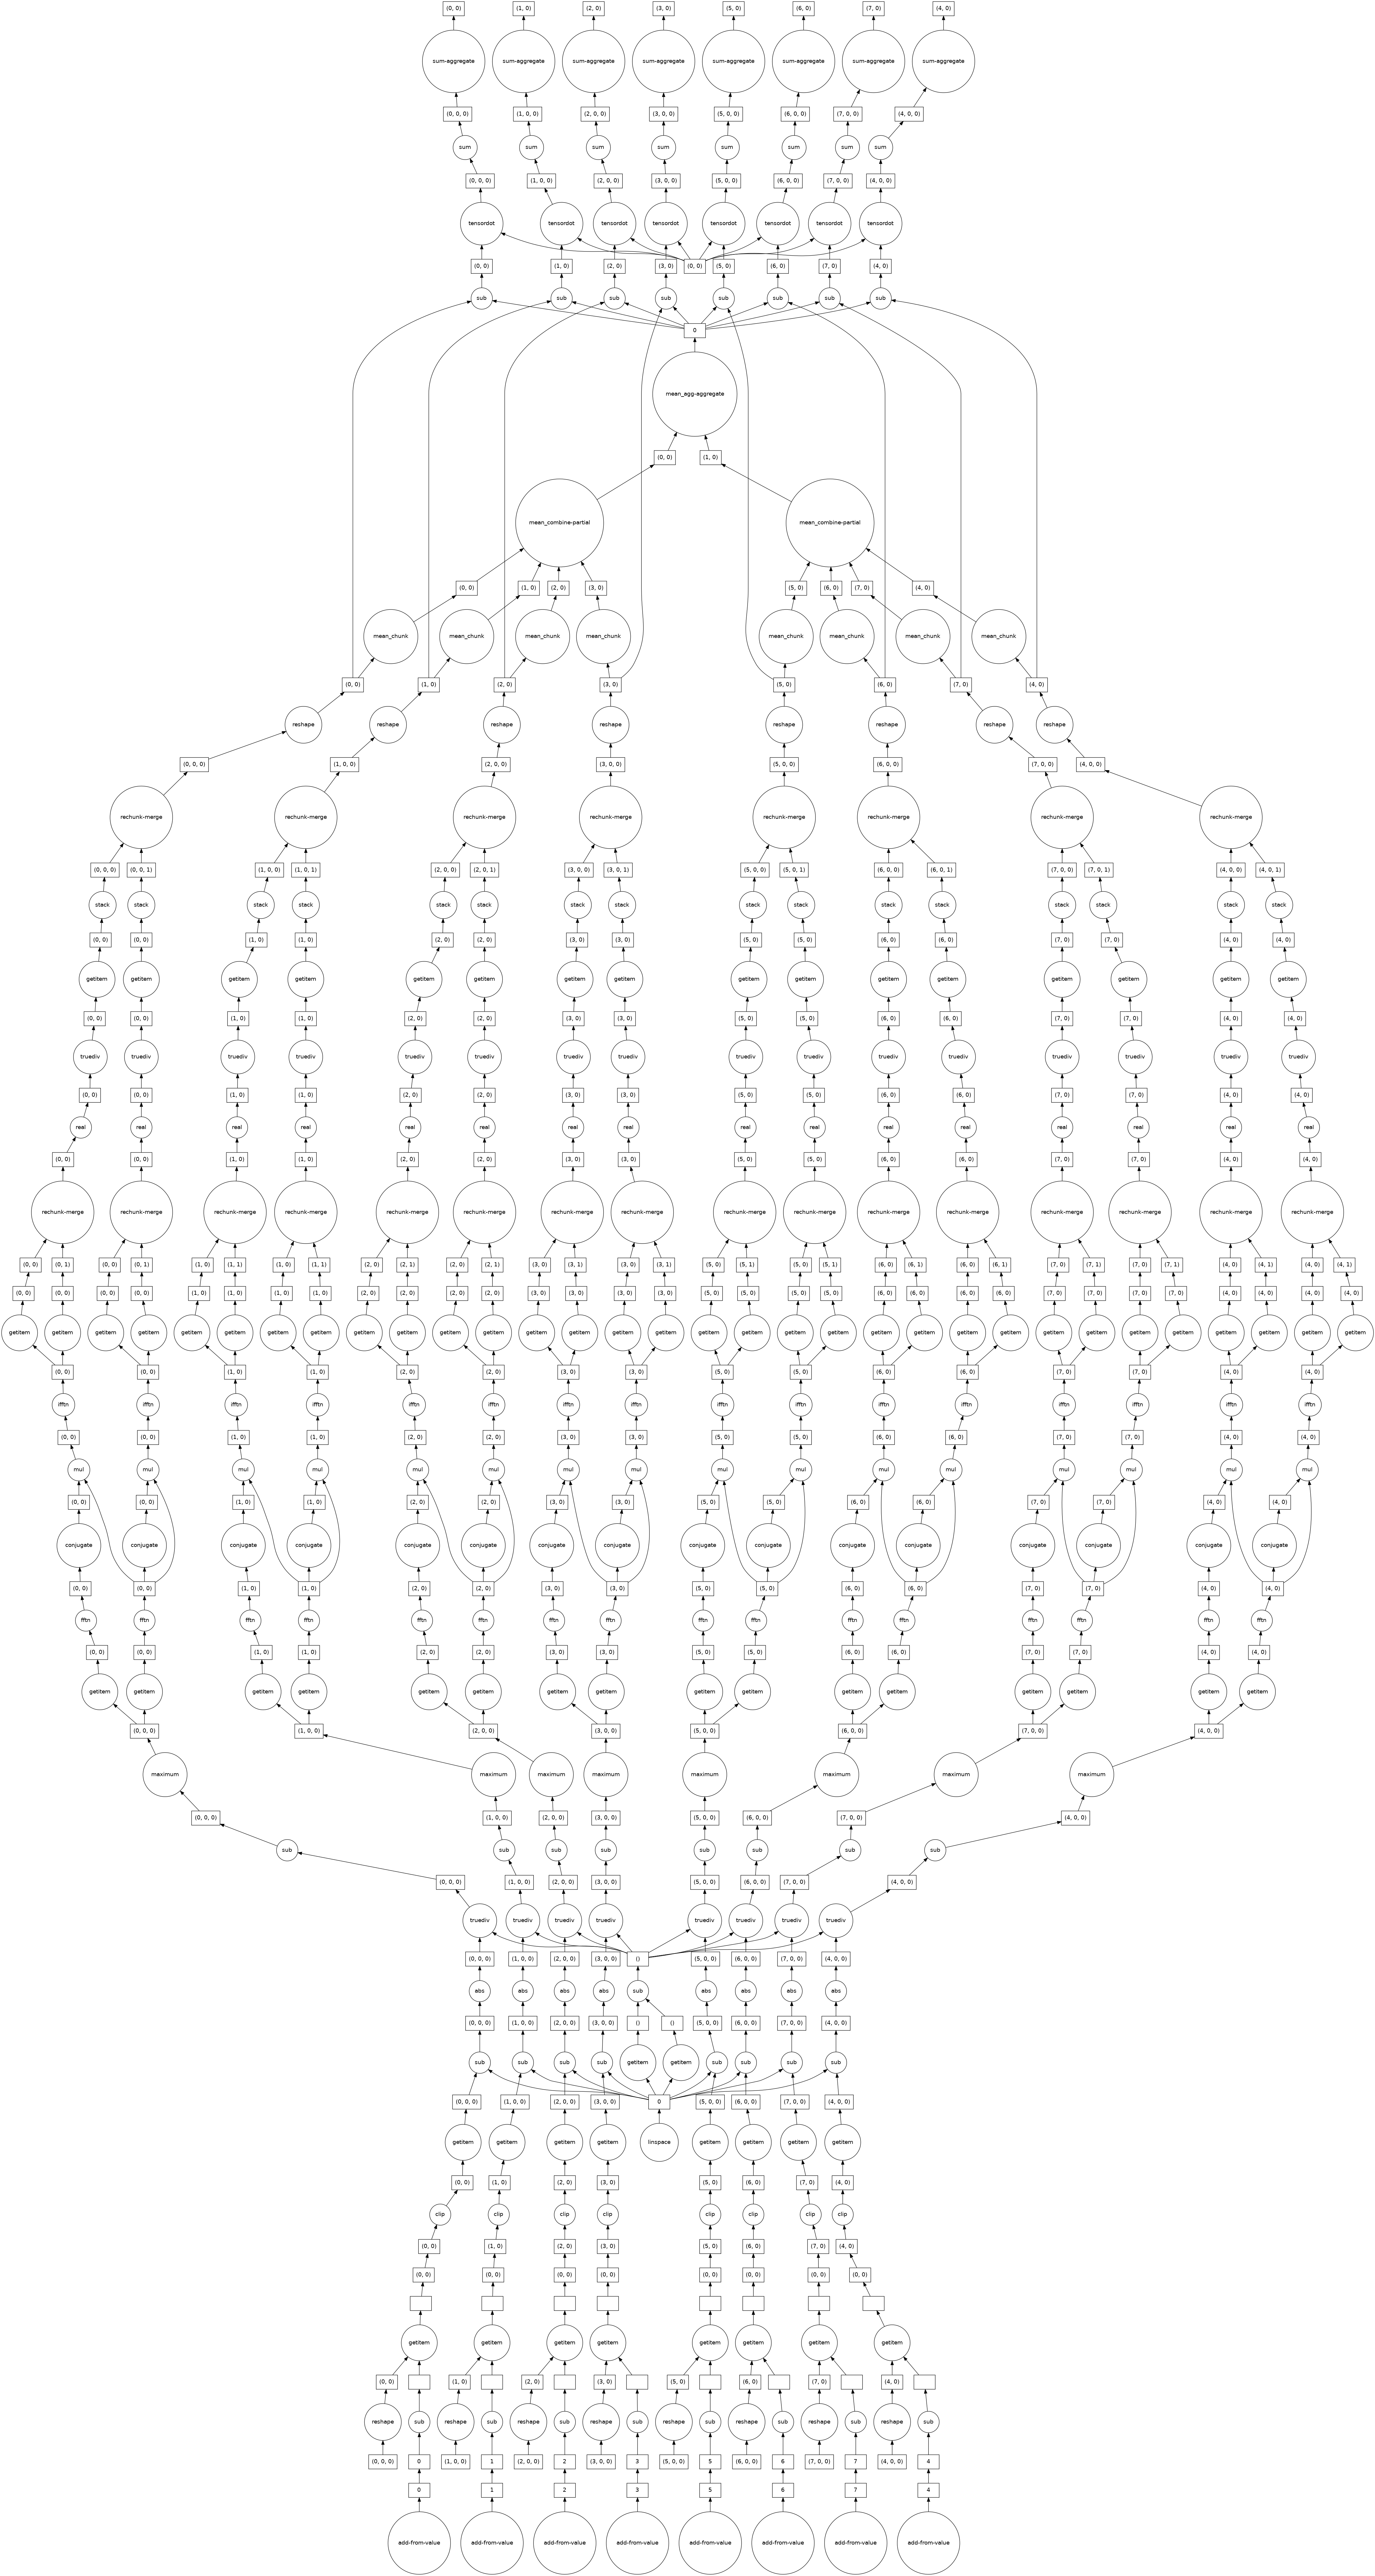

In [13]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

pca_pipeline.fit(x_train, np.array(y_train)).transform(x_train).visualize()

## Cross Validation

The following creates an homogenization pipeline and cross-validates the model. For more details about the two-points statistics view the [Checkerboard Microstructure Example](http://materialsinnovation.github.io/pymks/rst/checker_board.html). Use `GridSearchCV` to optimize the `n_components` and `degree` hyper-parameters for the model. Search over the range of 1st order to 3rd order degree polynomials and 2 to 7 principal components.

In [14]:
params_to_tune = {'pca__n_components': np.arange(1, 7),'poly__degree': np.arange(1, 4)}

grid_search = GridSearchCV(pipeline, param_grid=params_to_tune).fit(x_train, y_train)

Display the best model from the grid search and check that it is accurate.

In [15]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

print('Order of Polynomial',grid_search.best_params_.get('poly__degree'))
print('Number of Components', grid_search.best_params_.get('pca__n_components'))
print('R-squared Value', np.allclose(grid_search.score(x_test, y_test), 1.0, rtol=2e-2))

Order of Polynomial 3
Number of Components 5
R-squared Value True


In [26]:
assert (2 <= grid_search.best_params_.get('poly__degree') <= 3), grid_search.best_params_.get('poly__degree')
assert (4 <= grid_search.best_params_.get('pca__n_components') <= 6), grid_search.best_params_.get('pca__n_components')
assert np.allclose(grid_search.score(x_test, y_test), 1.0, rtol=2e-2), grid_search.score(x_test, y_test)

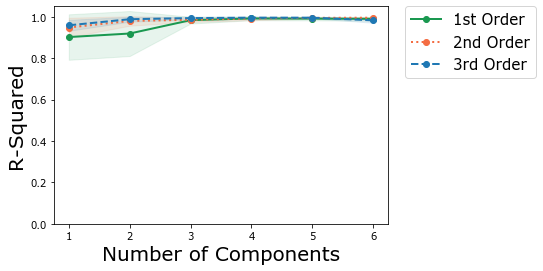

In [17]:
def plot_line(x, mean, std_dev, color, label, linestyle):
    plt.fill_between(x, mean - std_dev, mean + std_dev, alpha=0.1, color=color)
    plt.plot(x, mean, 'o-', color=color, label=label, linewidth=2, linestyle=linestyle)
    
def plot(dfs):
    [plot_line(
        df_.n_comp.astype(int),
        df_.mean_, df_.std_,
        df_.color.iloc[0],
        df_.label.iloc[0],
        df_.linestyle.iloc[0]
    )
     for df_ in dfs]
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
    plt.ticklabel_format(style='sci', axis='y')
    plt.ylabel('R-Squared', fontsize=20)
    plt.xlabel('Number of Components', fontsize=20)
    plt.ylim(0.0, 1.05)
    plt.show()

def add_labels(df):
    return df.assign(
        label=df.degree.map(lambda n: {1: '1st Order', 2: '2nd Order', 3: '3rd Order'}[n]),
        color=df.degree.map(lambda n: {1: '#1a9850', 2: '#f46d43', 3: '#1f78b4'}[n]),
        linestyle=df.degree.map(lambda n: {1: 'solid', 2: 'dotted', 3: 'dashed'}[n])
    )
    
def rename(df):
    return df.rename(
        dict(
            param_poly__degree='degree',
            param_pca__n_components='n_comp',
            mean_test_score='mean_',
            std_test_score='std_',
        ),
        axis=1
    )

def groupby(df, col):
    gb = df.groupby(col)
    return [gb.get_group(x) for x in gb.groups]

df = groupby(
    add_labels(
        rename(
            pandas.DataFrame(grid_search.cv_results_)
        )
    ),
    'degree'
)

plot(df)

The best model has `degree` equal to 3 and `n_components` equal to 5.

In [18]:
model = grid_search.best_estimator_

## Structures in PCA space

Plot the samples in 3D principle component space using a pipeline that omits both the polynomial features and the linear regression. This pipeline is a transform only pipeline, not a predicting pipeline.

In [19]:
pca_pipeline.set_params(pca__n_components=3);

Apply the `pca_pipeline` to the training dataset and testing dataset to obtain their principle component values.

In [20]:
x_trans_train = pca_pipeline.fit(x_train).transform(x_train).compute()
x_trans_test = pca_pipeline.transform(x_test).compute()

Visualize the principle component information in the 3D plot.

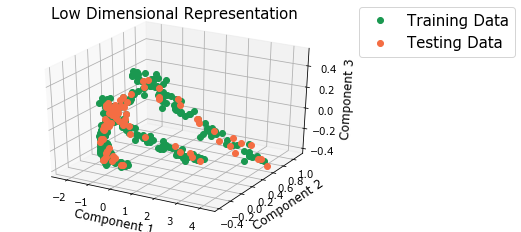

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Component 1', fontsize=12)
ax.set_ylabel('Component 2', fontsize=12)
ax.set_zlabel('Component 3', fontsize=12)
ax.plot(*x_trans_train.T, 'o', label='Training Data', color='#1a9850')
ax.plot(*x_trans_test.T, 'o', label='Testing Data', color='#f46d43')
plt.title('Low Dimensional Representation', fontsize=15)
plt.legend(loc=1, borderaxespad=0., fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0., fontsize=15)
plt.show()

There is agreement between the testing and the training data. There is also some separation between fiber types in PC space.  

## Parity Plot

The calculated average stress is plotted against the stress generate by the model.

In [22]:
y_train_predict = model.predict(x_train)
y_predict = model.predict(x_test)

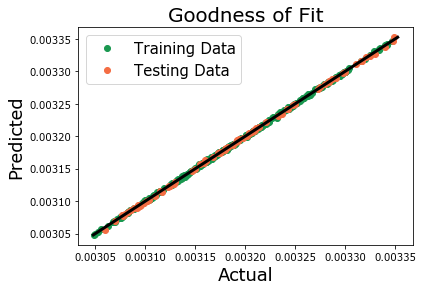

In [23]:
fit_data = np.array([y_train.compute(), y_train_predict])
pred_data = np.array([y_test.compute(), y_predict])

y_total = np.concatenate((fit_data, pred_data), axis=-1)
line = np.min(y_total), np.max(y_total)

plt.plot(fit_data[0], fit_data[1], 'o', color='#1a9850', label='Training Data')
plt.plot(pred_data[0], pred_data[1], 'o', color='#f46d43', label='Testing Data')
plt.plot(line, line, '-', linewidth=3, color='#000000')
plt.title('Goodness of Fit', fontsize=20)
plt.xlabel('Actual', fontsize=18)
plt.ylabel('Predicted', fontsize=18)
plt.legend(loc=2, fontsize=15)
plt.show()

There is a good correlation between the FE results and those predicted by the linkage.  